In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import Pool
from catboost.utils import get_roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

from sklearn.metrics import (roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, \
                             classification_report, plot_confusion_matrix, recall_score, \
                             plot_precision_recall_curve, precision_recall_curve, plot_roc_curve)
import copy

In [2]:
train = pd.read_csv("../assignment2_data/assignment_2_train.csv")
test = pd.read_csv("../assignment2_data/assignment_2_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


In [3]:
train.head().style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

In [4]:
train.describe().round(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,180000.00,180000.00,180000.00,180000.00,180000.00,177389.00,179997.00,179047.00,160567.00,160567.00,...,47996.00,47996.00,47996.00,47996.00,47996.00,47996.0,47996.00,47996.0,47996.00,47996.00
mean,3076999.50,0.03,1909817.98,129.51,9860.23,368.33,153.41,200.36,291.16,86.56,...,0.14,74.96,99.22,85.78,8.33,18.4,12.44,26.8,32.01,28.49
std,51961.67,0.17,1039028.63,206.52,4910.78,158.95,11.53,40.59,102.25,3.96,...,0.64,545.16,668.22,577.07,84.62,120.9,99.31,252.7,284.87,258.37
min,2987000.00,0.00,86400.00,0.29,1001.00,100.00,100.00,100.00,100.00,10.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00
25%,3031999.75,0.00,1091680.75,44.00,6019.00,215.00,150.00,166.00,204.00,87.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00
50%,3076999.50,0.00,1884075.00,75.00,9633.00,375.00,150.00,226.00,299.00,87.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00
75%,3121999.25,0.00,2693195.50,125.00,14182.00,514.00,150.00,226.00,330.00,87.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00
max,3166999.00,1.00,3958317.00,5278.95,18396.00,600.00,231.00,237.00,540.00,102.00,...,15.00,20750.00,32250.00,21250.00,3100.00,3350.0,3250.00,8250.0,8250.00,8250.00


In [5]:
test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.00,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.00,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3287002,0,7415081,319.95,W,13844,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3287003,0,7415111,171.00,W,11556,309.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3287004,0,7415112,107.95,W,10985,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
TransactionID,100001.0,3337000.00,28867.95,3287000.00,3312000.00,3337000.00,3362000.00,3387000.00
isFraud,100001.0,0.04,0.19,0.00,0.00,0.00,0.00,1.00
TransactionDT,100001.0,8696663.26,760390.85,7415038.00,8023328.00,8630067.00,9346592.00,10091550.00
TransactionAmt,100001.0,140.67,240.27,0.25,44.53,73.97,134.95,5543.23
card1,100001.0,9882.20,4867.29,1004.00,6019.00,9633.00,14065.00,18395.00
...,...,...,...,...,...,...,...,...
V335,6774.0,36.25,269.73,0.00,0.00,0.00,0.00,12307.50
V336,6774.0,11.97,216.32,0.00,0.00,0.00,0.00,12307.50
V337,6774.0,47.60,597.99,0.00,0.00,0.00,0.00,25000.00
V338,6774.0,52.68,600.45,0.00,0.00,0.00,0.00,25000.00


Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [7]:
# выделим числовые признаки
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features_train {numerical_features.shape[1]}")
numerical_features.columns

count of numeric_features_train 380


Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=380)

In [8]:
y_train = numerical_features["isFraud"]
x_train = numerical_features.drop(["isFraud"], axis=1)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))

y_valid = test["isFraud"]
x_valid = test[numerical_features.columns].drop(["isFraud"], axis=1)
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 180000 rows, 379 cols
x_valid.shape = 100001 rows, 379 cols


In [9]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

In [10]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    #"n_estimators": 500,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 4,
    "seed": 42
}

In [40]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True
)

[0]	train-auc:0.649994	valid-auc:0.622395
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[20]	train-auc:0.821853	valid-auc:0.779933
[40]	train-auc:0.873315	valid-auc:0.845025
[60]	train-auc:0.889123	valid-auc:0.85419
[80]	train-auc:0.895291	valid-auc:0.855624
[100]	train-auc:0.900233	valid-auc:0.856056
[120]	train-auc:0.903725	valid-auc:0.857625
[140]	train-auc:0.906922	valid-auc:0.858554
[160]	train-auc:0.909769	valid-auc:0.858654
[180]	train-auc:0.911692	valid-auc:0.859646
[200]	train-auc:0.91227	valid-auc:0.859834
Stopping. Best iteration:
[182]	train-auc:0.911963	valid-auc:0.859842



Вывод: при отсутствии улучшения метрики (на valid) за 20 итераций при заданных параметрах алгоритм останавливается, наилучший результат roc-auc 0.859842

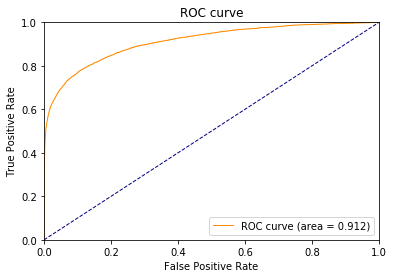

In [42]:
pred_proba_test = model.predict(dtrain)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ROC-AUC на тесте
pred_proba_test = model.predict(x_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [55]:
%%time
#Кросс-валидация на трейне

from sklearn.model_selection import cross_val_score, KFold
parameters = {"max_depth": 4, "n_estimators": 500, "random_state": 42, "n_jobs": 4, "learning_rate": 0.1, "reg_lambda": 100, "gamma": 10,"early_stopping_rounds":20}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=x_train, y=y_train,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
)

print(f"CV-score: {round(np.mean(cv), 4)}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV-score: 0.8955
Wall time: 10min 40s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.7min finished


Кросс-валидация на трейне показывает результат 0.8955

Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

Произведем dummy кодирование. Объединим датасеты (для обеспечения одинаковой стуктуры), закодируем признаки и затем разделим их

In [11]:
data = pd.concat(objs=[train,test],axis=0)
data = pd.get_dummies(data)
data.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,...,1,0,0,1,0,0,0,0,0,0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0,1,0,1,0,0,0,0,0,0


In [12]:
train_hotcoded = data[:train.shape[0]].copy()
train_hotcoded.shape

(180000, 531)

In [13]:
test_hotcoded = data[train.shape[0]:].copy()
test_hotcoded.shape

(100001, 531)

In [14]:
y_train = train_hotcoded["isFraud"]
x_train = train_hotcoded.drop(["isFraud"], axis=1)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))

y_valid = test_hotcoded["isFraud"]
x_valid = test_hotcoded.drop(["isFraud"], axis=1)
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 180000 rows, 530 cols
x_valid.shape = 100001 rows, 530 cols


In [15]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

In [24]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=20,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=20,
    maximize=True
)

[0]	train-auc:0.649994	valid-auc:0.622395
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[20]	train-auc:0.821993	valid-auc:0.780109
[40]	train-auc:0.873909	valid-auc:0.85016
[60]	train-auc:0.895062	valid-auc:0.858915
[80]	train-auc:0.903183	valid-auc:0.861698
[100]	train-auc:0.908933	valid-auc:0.862731
[120]	train-auc:0.91287	valid-auc:0.86421
[140]	train-auc:0.915702	valid-auc:0.865651
[160]	train-auc:0.917896	valid-auc:0.866289
[180]	train-auc:0.917896	valid-auc:0.866289
Stopping. Best iteration:
[160]	train-auc:0.917896	valid-auc:0.866289



При текущих параметрах и остановке алгоритма в случае отсутствия улучшения метрики на 20 итерациях остановка происходит на 160 итерации, метрика на valid 0.866289. Метрика на valid незначительно улучшилась (менее 0.01)

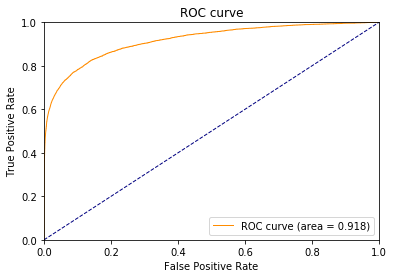

In [25]:
#Построим ROC (valid)
pred_proba_test = model.predict(dtrain)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ROC-AUC на тесте
pred_proba_test = model.predict(x_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
%%time
#Кросс-валидация на трейне

from sklearn.model_selection import cross_val_score, KFold
parameters = {"max_depth": 4, "n_estimators": 500, "random_state": 42, "n_jobs": 4, "learning_rate": 0.1, "reg_lambda": 100, "gamma": 10,"early_stopping_rounds":20}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=x_train, y=y_train,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.904
Wall time: 24min 50s


Кросс-валидация на трейне показывает результат 0.904

Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [16]:
y_train = numerical_features["isFraud"]
x_train = numerical_features.drop(["isFraud"], axis=1)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))

y_valid = test["isFraud"]
x_valid = test[numerical_features.columns].drop(["isFraud"], axis=1)
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 180000 rows, 379 cols
x_valid.shape = 100001 rows, 379 cols


In [17]:
dtrain = lgb.Dataset(data=x_train, label=y_train)
dvalid = lgb.Dataset(data=x_valid, label=y_valid)

In [24]:
params = { 
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": 4,
    "seed": 42
}
#перебрал 0.01 0.05 0.10 Дольше но лучше на 0.01

In [25]:
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=20,
    verbose_eval=10
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32181
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 377
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.832852	valid_1's auc: 0.798164
[20]	training's auc: 0.839753	valid_1's auc: 0.800759
[30]	training's auc: 0.867304	valid_1's auc: 0.839369
[40]	training's auc: 0.870866	valid_1's auc: 0.841879
[50]	training's auc: 0.8742	valid_1's auc: 0.84369
[60]	training's auc: 0.880805	valid_1's auc: 0.850199
[70]	training's auc: 0.882641	valid_1's auc: 0.851854


Вывод: при отсутствии улучшения метрики (на valid) за 20 итераций при заданных параметрах алгоритм останавливается, наилучший результат roc-auc 0.857897. Значение хуже чем у xgb без категориальных признаков.

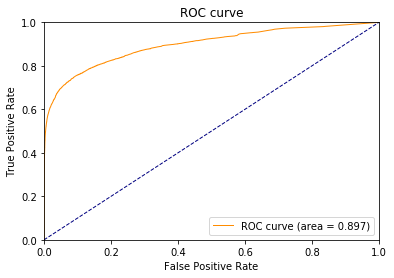

In [27]:
#ROC-AUC
pred_proba_test = model.predict(x_train)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ROC-AUC на тесте
pred_proba_test = model.predict(x_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [28]:
y_train = train_hotcoded["isFraud"]
x_train = train_hotcoded.drop(["isFraud"], axis=1)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))

y_valid = test_hotcoded["isFraud"]
x_valid = test_hotcoded.drop(["isFraud"], axis=1)
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 180000 rows, 530 cols
x_valid.shape = 100001 rows, 530 cols


In [29]:
dtrain = lgb.Dataset(data=x_train, label=y_train)
dvalid = lgb.Dataset(data=x_valid, label=y_valid)

In [30]:
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=20,
    verbose_eval=10
)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.512750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32429
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 501
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.83331	valid_1's auc: 0.798038
[20]	training's auc: 0.838777	valid_1's auc: 0.801568
[30]	training's auc: 0.866971	valid_1's auc: 0.837035
[40]	training's auc: 0.877027	valid_1's auc: 0.847375


При текущих параметрах алгоритм проходит 500 итераций без ранней остановки (оставил 500 для сопоставимости), метрика на valid 0.873223. Метрика на valid улучшилась (на 0.02), по сравнению с xgb также улучшилась.

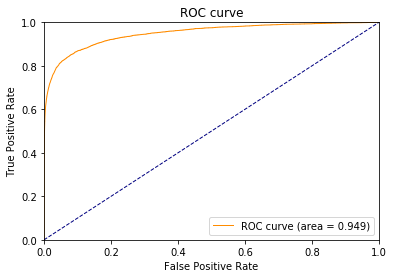

In [32]:
#ROC-AUC
pred_proba_test = model.predict(x_train)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#ROC-AUC на тесте
pred_proba_test = model.predict(x_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [85]:
%time
from sklearn.model_selection import cross_val_score, KFold
params = { 
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": 4,
    "seed": 42
}

cv_results = lgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        nfold=3,
        #metrics="roc_auc",
        early_stopping_rounds=20
        )
#print(f"CV-score: {round(np.mean(cv), 4)}")

Wall time: 0 ns
[LightGBM] [Info] Number of positive: 3428, number of negative: 116572
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32429
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 501
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32429
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 501
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

In [88]:
cv_results['auc-mean'][-1] #Значение метрики на последней итерации

0.8889712888998579

Вывод: Кросс-валидация на трейне показывает результат 0.88897 Это хуже результата XGB на кросс-валидации

Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [91]:
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns, len(categorical_features.columns)

(Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
        'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
       dtype='object'),
 14)

In [93]:
#Проверим наличие типа "category"
train.select_dtypes(include="category").columns

Index([], dtype='object')

In [96]:
# Переведем категориальные в тип "category"
cat_features = categorical_features.columns.tolist()
train[cat_features] = train[cat_features].astype("category")
test[cat_features] = test[cat_features].astype("category")
#train.select_dtypes(include="category").columns # проверка

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [97]:
y_train = train["isFraud"]
x_train = train.drop(["isFraud"], axis=1)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))

y_valid = test["isFraud"]
x_valid = test.drop(["isFraud"], axis=1)
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 180000 rows, 393 cols
x_valid.shape = 100001 rows, 393 cols


In [98]:
dtrain = lgb.Dataset(data=x_train, label=y_train, categorical_feature=cat_features)
dvalid = lgb.Dataset(data=x_valid, label=y_valid, categorical_feature=cat_features)

In [99]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": 4,
    "seed": 42
}

In [100]:
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    categorical_feature=cat_features,
    early_stopping_rounds=20,
    verbose_eval=10
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.368504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32346
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 391


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.833171	valid_1's auc: 0.798366
[20]	training's auc: 0.840287	valid_1's auc: 0.801934
[30]	training's auc: 0.869058	valid_1's auc: 0.83976
[40]	training's auc: 0.876823	valid_1's auc: 0.847299
[50]	training's auc: 0.88004	valid_1's auc: 0.848232
[60]	training's auc: 0.886461	valid_1's auc: 0.853643
[70]	training's auc: 0.890668	valid_1's auc: 0.855393
[80]	training's auc: 0.893365	valid_1's auc: 0.855205
Early stopping, best iteration is:
[68]	training's auc: 0.890063	valid_1's auc: 0.855658


In [101]:
model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=500,
    valid_sets=[dtrain, dvalid],
    categorical_feature=cat_features,
    early_stopping_rounds=30,
    verbose_eval=10
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.460695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32346
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 391
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 30 rounds
[10]	training's auc: 0.833171	valid_1's auc: 0.798366
[20]	training's auc: 0.840287	valid_1's auc: 0.801934
[30]	training's auc: 0.869058	valid_1's auc: 0.83976
[40]	training's auc: 0.876823	valid_1's auc: 0.847299
[50]	training's auc: 0.88004	valid_1's auc: 0.848232
[60]	training's auc: 0.886461	valid_1's auc: 0.853643
[70]	training's auc: 0.890668	valid_1's auc: 0.855393

Увеличил early_stopping до 30 итераций, так как при 20 по всей видимости застряли в локальном минимуме. Алгоритм отработал все 500 итераций (для сопоставимости), метрика на valid 0.871085 что незначительно хуже результата при обработке категориальных признаков внешними обработчиками. При этом время обработки также незначительно сократилось.

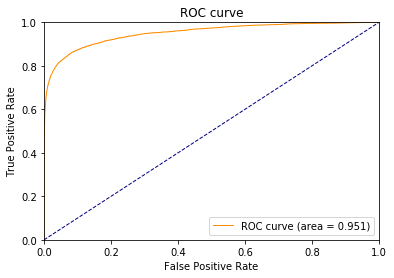

In [103]:
#ROC-AUC на трейне
pred_proba_test = model.predict(x_train)

fpr, tpr, thresholds = roc_curve(y_train, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

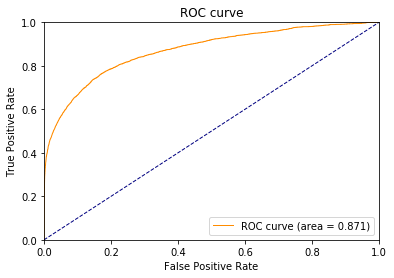

In [104]:
#ROC-AUC на тесте
pred_proba_test = model.predict(x_valid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Вывод: По ROC-AUC заметно небольшое переобучение, на тесте 0.95 на трейне 0.87

In [105]:
%time
#Кросс-валидация на valid
params = { 
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": 4,
    "seed": 42
}

cv_results = lgb.cv(
        params,
        dtrain,
        categorical_feature=cat_features,
        num_boost_round=500,
        nfold=3,
        #metrics="roc_auc",
        early_stopping_rounds=30
        )

Wall time: 0 ns
[LightGBM] [Info] Number of positive: 3428, number of negative: 116572
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32346
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 391
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32346
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 391
[LightGBM] [Info] Number of positive: 3427, number of negative: 116573
[LightGBM] [Warning] Auto-choosing row-wise multi-thr

In [107]:
cv_results['auc-mean'][-1]

0.9273290469246817

Вывод: метрика на кросс-валидации значительно лучше, чем при внешней обработке категориальных признаков, и лучше, чем у модели xgb

По схеме валидации я выбрал кросс-валидацию на трейне. Не уверен что верно реализовал для lgb, вообще все еще вникаю как настраивать кросс-валидацию с этими моделями, которые отличаются по api от стандартных sk-learn